# Diffusing Neural Cellular Automata

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [26]:
import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.conv_perceive import ConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.utils.emoji import get_emoji
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [6]:
seed = 0

channel_size = 64
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5

batch_size = 8
num_steps = 64
learning_rate = 1e-3

emoji = "🦎"
target_size = 40
target_padding = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

""

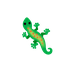

In [7]:
target = get_emoji(emoji, size=target_size, padding=target_padding)

mediapy.show_image(target)

## Init state

In [8]:
def add_noise(target, alpha, key):
	noise = jax.random.normal(key, target.shape)
	noisy_image = (1 - alpha) * target + alpha * noise
	return jnp.clip(noisy_image, 0.0, 1.0)


def init_state(key):
	state = jnp.zeros(target.shape[:2] + (channel_size,))

	alpha_key, noise_key = jax.random.split(key)
	alpha = jax.random.uniform(alpha_key)
	noise = jax.random.normal(noise_key, target.shape)
	noisy_target = (1 - alpha) * target + alpha * noise

	return state.at[..., -4:].set(noisy_target)

## Model

In [9]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
)

In [10]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.conv.kernel = nnx.Param(kernel)

In [11]:
ca = CA(perceive, update)

In [12]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 67584


## Train

### Optimizer

In [13]:
lr_sched = optax.linear_schedule(
	init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000
)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [14]:
def mse(state):
	return jnp.mean(jnp.square(state_to_rgba(state) - target))

In [15]:
@nnx.jit
def loss_fn(ca, state):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	loss = mse(state)
	return loss

### Train step

In [16]:
@nnx.jit
def train_step(ca, optimizer, key):
	keys = jax.random.split(key, batch_size)
	current_state = jax.vmap(init_state)(keys)

	loss, grad = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, update_params))(
		ca, current_state
	)
	optimizer.update(grad)

	return loss

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss = train_step(ca, optimizer, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.3e}"})

## Visualize

In [24]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, 8)
state = jax.vmap(init_state)(keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=8)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
		in_axes=(state_axes, 0),
	)
)(ca, state)

,,,,,,,

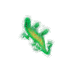
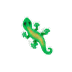
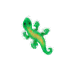
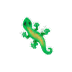
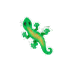
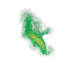
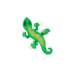
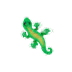

,,,,,,,

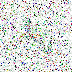
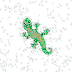
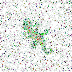
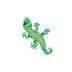
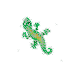
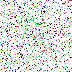
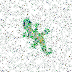
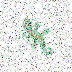

In [25]:
mediapy.show_images(state_to_rgba(state[:, -1]), width=128, height=128)
mediapy.show_videos(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")